In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        # print(os.path.join(dirname, filename))
        continue
print('DONE')
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

DONE


In [2]:
#importing required libraries for the job

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import matplotlib.pyplot as plt
import numpy as np

In [3]:
 # Check if any GPU is available
 device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
 # If a CUDA device is available, use the first available GPU
 if torch.cuda.is_available():
  device = torch.device("cuda:0")  # Using the first available GPU at index 0
 else:
  device = torch.device("cpu")
 print(f"Using device: {device}")

Using device: cuda:0


In [4]:
#Loading the dataset from drive
dataset_path = '/kaggle/input/realwaste/realwaste-main/RealWaste'

In [5]:
global IMAGE_SIZE, BATCH_SIZE, CHANNELS, NUM_CLASSES, EPOCH
IMAGE_SIZE = 256
BATCH_SIZE = 16
CHANNELS = 3
EPOCH = 80

In [6]:

transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),  # Making sure that the size is fixed for all
    transforms.ToTensor(), # Convert to tensor
])

#Load dataset from directory
dataset = ImageFolder(root=dataset_path, transform=transform)


In [7]:
CLASSES = dataset.classes
NUM_CLASSES = len(CLASSES)
print(NUM_CLASSES)

# View class names (subfolder names)
print("Class Names:")
for class_name in dataset.classes:
    print(class_name)


# View class-to-index mapping
print("\nClass-to-Index Mapping:")
for class_name, index in dataset.class_to_idx.items():
    print(f"{index}: {class_name}")

# View total number of samples
print("\nNumber of images:", len(dataset))

# View a single sample (image and label)
img1, label1 = dataset[0]  # Access the first sample
print("Image shape:", img1.shape)  # Shape of the image tensor
print("Label:", label1)  # Integer label corresponding to the class

9
Class Names:
Cardboard
Food Organics
Glass
Metal
Miscellaneous Trash
Paper
Plastic
Textile Trash
Vegetation

Class-to-Index Mapping:
0: Cardboard
1: Food Organics
2: Glass
3: Metal
4: Miscellaneous Trash
5: Paper
6: Plastic
7: Textile Trash
8: Vegetation

Number of images: 4752
Image shape: torch.Size([3, 256, 256])
Label: 0


In [8]:
#splitting the dataset into 70% , 15% and 15% for train, test and valid

train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, valid_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create DataLoaders for validation and test sets

#Set a seed for reproducibility
torch.manual_seed(42)
train_loader = DataLoader(train_dataset, batch_size= BATCH_SIZE, shuffle=True,
                           num_workers=4,               # Number of workers for data loading
                           pin_memory=True,             # Use pinned memory for GPU transfer
                           prefetch_factor=2,            # Number of batches to prefetch per workers
                           persistent_workers=True      # Keep workers alive between epochs
                         )
# Set a seed for reproducibility
torch.manual_seed(42)
valid_loader = DataLoader(valid_dataset, batch_size= BATCH_SIZE, shuffle=True,
                           num_workers=4,               # Number of workers for data loading
                           pin_memory=True,             # Use pinned memory for GPU transfer
                           prefetch_factor=2,            # Number of batches to prefetch per workers
                           persistent_workers=True      # Keep workers alive between epochs
                         )


# Set a seed for reproducibility
torch.manual_seed(42)
test_loader = DataLoader(test_dataset,  batch_size= BATCH_SIZE, shuffle=True,
                           num_workers=4,               # Number of workers for data loading
                           pin_memory=True,             # Use pinned memory for GPU transfer
                           prefetch_factor=2,            # Number of batches to prefetch per workers
                           persistent_workers=True      # Keep workers alive between epochs
                         )

In [9]:
# Check the size of SETS
print(f"Training set size: {len(train_loader)}")
print(f"Validation set size: {len(valid_loader)}")
print(f"Test set size: {len(test_loader)}")

Training set size: 208
Validation set size: 45
Test set size: 45


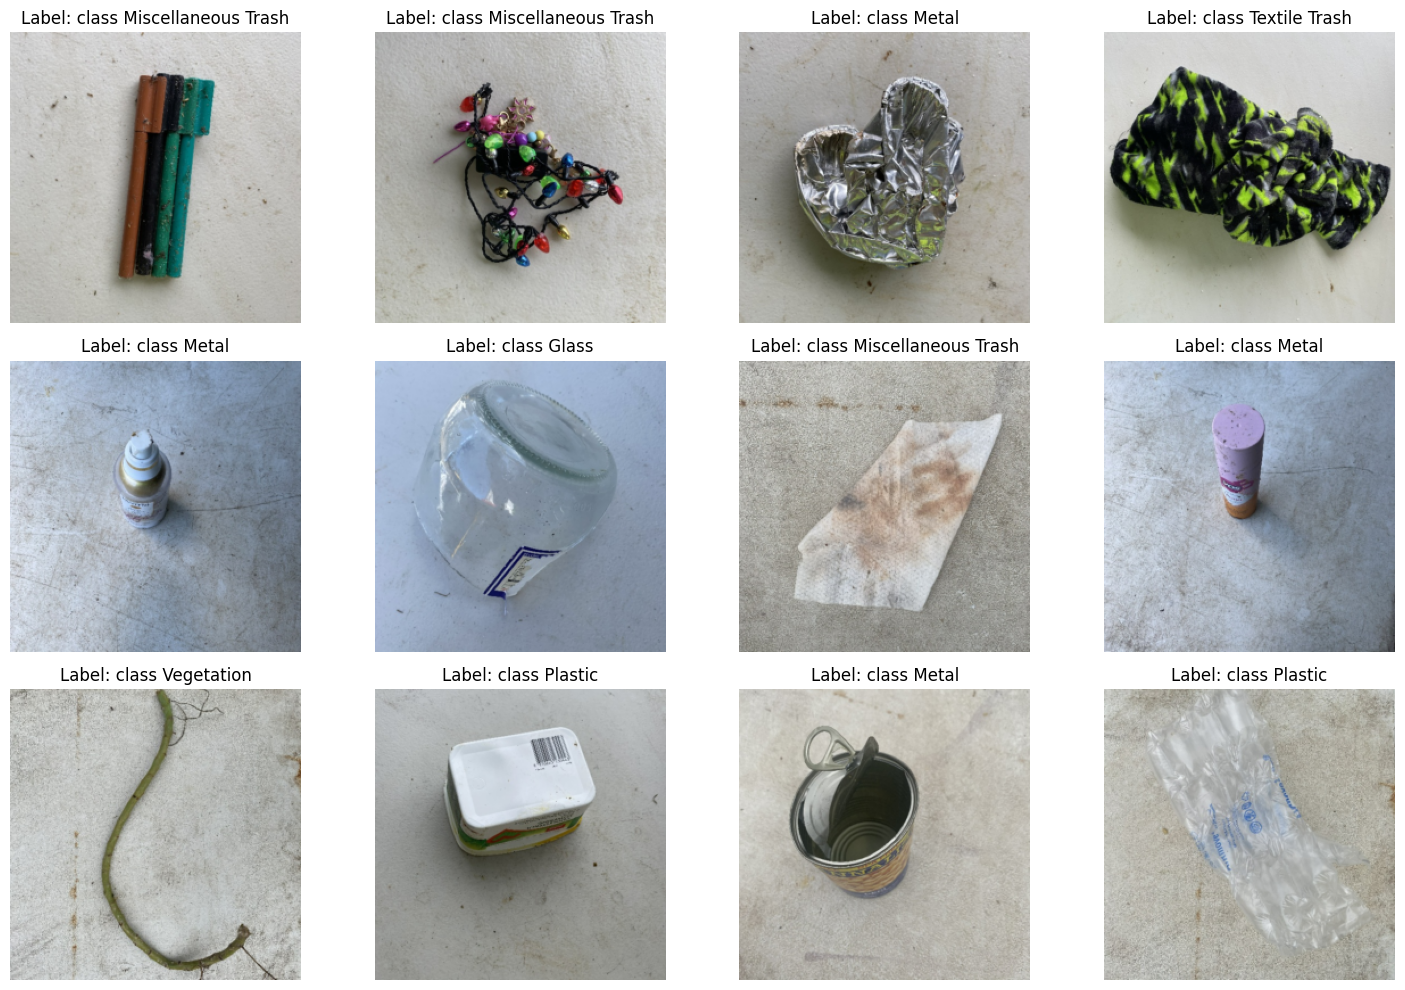

In [10]:
#for a singular image
for images, labels in train_loader:
  fig, axes = plt.subplots(3, 4, figsize=(15, 10))

  # Plot the first 12 images
  for i in range(12):
      row, col = divmod(i, 4)
      ax = axes[row, col]
      ax.imshow(images[i].permute(1, 2, 0))  # Change from C x H x W to H x W x C)
      ax.set_title(f"Label: class {CLASSES[labels[i].item()]}") #display class name
      ax.axis('off')  # Turn off axes

  plt.tight_layout()
  plt.show()
  break


In [11]:
# =====================================================
# Defining the CNN initially on an arbitrary basis!!!
# =====================================================
class WasteCNN(nn.Module):
    def __init__(self, num_classes):
        super(WasteCNN, self).__init__()

        # Conv1: 3x3 kernel
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)

        # Conv2: 3x3 kernel with stride
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1)

        # Conv3: 5x5 kernel
        self.conv3 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
        self.pool2 = nn.MaxPool2d(2, 2)

        # Fully connected layers
        # Input: 64 * 32 * 32 (after last pooling for 256x256 input)
        self.fc1 = nn.Linear(64 * 32 * 32, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)

        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.pool2(x)

        x = x.view(x.size(0), -1)  # flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return F.log_softmax(x, dim=1)

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# =====================================================
# 4. Defining a deeper and more complex CNN: BigWasteCNN
# =====================================================
class BigWasteCNN(nn.Module):
    def __init__(self, num_classes):
        super(BigWasteCNN, self).__init__()

        # ----- Convolutional feature extractor -----
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),   # 256 → 128

            # Block 2
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),   # 128 → 64

            # Block 3
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),   # 64 → 32

            # Block 4
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),   # 32 → 16

            # Block 5
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),   # 16 → 8
        )

        # ----- Fully connected head -----
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 8 * 8, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return F.log_softmax(x, dim=1)


In [13]:
# =====================================================
# Moderate complexity CNN: ShapeEkeWasteCNN
# =====================================================
class ShapeEkeWasteCNN(nn.Module):
    def __init__(self, num_classes):
        super(ShapeEkeWasteCNN, self).__init__()

        # ----- Feature extraction -----
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),   # 256 → 128

            # Block 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),   # 128 → 64

            # Block 3
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),   # 64 → 32

            # Block 4
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),   # 32 → 16
        )

        # ----- Classification head -----
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 16 * 16, 512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return F.log_softmax(x, dim=1)

In [14]:
# ==== Modular Training Function ====
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=100, device='gpu'):
    train_losses, val_losses, val_accs = [], [], []

    for epoch in range(num_epochs):
        # ---- Training ----
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # ---- Validation ----
        model.eval()
        val_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        val_acc = 100 * correct / total
        val_accs.append(val_acc)

        print(f"Epoch [{epoch+1}/{num_epochs}] "
              f"| Train Loss: {avg_train_loss:.4f} "
              f"| Val Loss: {avg_val_loss:.4f} "
              f"| Val Acc: {val_acc:.2f}%")
        
       # # Early stopping check
       # if early_stopping(avg_val_loss, model):
       #     print("Early stopping triggered!")
       #     model.load_state_dict(early_stopping.best_model)
       #     break
    # ---- Return metrics ----
    return train_losses, val_losses, val_accs


In [15]:
# ==== Evaluation Function ====
def evaluate_model(model, test_loader, device='cpu'):
    model.eval()
    correct, total = 0, 0
    y_true, y_pred = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            
            _, predicted = torch.max(outputs.data, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    acc = 100 * correct / total
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
    cm = confusion_matrix(y_true, y_pred)

    print(f"\nTest Accuracy: {acc:.2f}%")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")
    print("Confusion Matrix:\n", cm)

    return acc, precision, recall, f1, cm


In [16]:
LEARNING_RATE = 0.001
criterion = nn.CrossEntropyLoss()

In [17]:
# ==== Plotting Function ====
def plot_loss_curves(train_losses, val_losses, title="Training and Validation Loss"):
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(title)
    plt.grid(True)
    plt.show()

# def plot_acc_curves( val_accs, title="Validation Accuracy Curve"):
def plot_acc_curves( val_accs, title):
    # plt.plot(train_losses, label='Training Loss')
    plt.plot(val_accs, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.title(title)
    plt.grid(True)
    plt.show()

In [18]:
import torch
import pandas as pd

def save_model_and_logs(model, model_name, train_losses, val_losses, val_accs, save_dir="/kaggle/working"):
    """
    Saves model weights and training logs for a given model.
    
    Args:
        model: Trained PyTorch model
        model_name: String, name of the model (used for filenames)
        train_losses, val_losses, val_accs: Lists of metrics
        save_dir: Directory to save files (default: /kaggle/working)
    """
    # === Save model weights ===
    model_path = f"{save_dir}/{model_name}_final.pth"
    torch.save(model.state_dict(), model_path)
    print(f"✅ Saved model weights to: {model_path}")

    # === Save training logs ===
    df = pd.DataFrame({
        "epoch": list(range(1, len(train_losses)+1)),
        "train_loss": train_losses,
        "val_loss": val_losses,
        "val_acc": val_accs
    })

    csv_path = f"{save_dir}/{model_name}_log.csv"
    df.to_csv(csv_path, index=False)
    print(f"📊 Saved training log to: {csv_path}")

    print("------------------------------------------------------")

print("Done")

Done


In [19]:
model_1 = WasteCNN(num_classes=NUM_CLASSES)

from torchsummary import summary

model_1.to(device)
summary(model_1, input_size=(3, 256, 256))  # (Channels, Height, Width)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 256, 256]             448
         MaxPool2d-2         [-1, 16, 128, 128]               0
            Conv2d-3           [-1, 32, 64, 64]           4,640
            Conv2d-4           [-1, 64, 64, 64]          51,264
         MaxPool2d-5           [-1, 64, 32, 32]               0
            Linear-6                  [-1, 256]      16,777,472
            Linear-7                    [-1, 9]           2,313
Total params: 16,836,137
Trainable params: 16,836,137
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.75
Forward/backward pass size (MB): 13.50
Params size (MB): 64.22
Estimated Total Size (MB): 78.48
----------------------------------------------------------------


Epoch [1/30] | Train Loss: 1.9627 | Val Loss: 1.7163 | Val Acc: 39.47%
Epoch [2/30] | Train Loss: 1.5020 | Val Loss: 1.4456 | Val Acc: 48.74%
Epoch [3/30] | Train Loss: 1.2237 | Val Loss: 1.2756 | Val Acc: 54.78%
Epoch [4/30] | Train Loss: 0.9967 | Val Loss: 1.1317 | Val Acc: 60.53%
Epoch [5/30] | Train Loss: 0.8651 | Val Loss: 1.0962 | Val Acc: 62.78%
Epoch [6/30] | Train Loss: 0.7170 | Val Loss: 1.1902 | Val Acc: 62.78%
Epoch [7/30] | Train Loss: 0.5719 | Val Loss: 1.2177 | Val Acc: 63.76%
Epoch [8/30] | Train Loss: 0.3574 | Val Loss: 1.4619 | Val Acc: 59.83%
Epoch [9/30] | Train Loss: 0.2349 | Val Loss: 1.5238 | Val Acc: 62.64%
Epoch [10/30] | Train Loss: 0.1565 | Val Loss: 1.5590 | Val Acc: 63.62%
Epoch [11/30] | Train Loss: 0.1209 | Val Loss: 2.0186 | Val Acc: 63.20%
Epoch [12/30] | Train Loss: 0.0536 | Val Loss: 2.2495 | Val Acc: 62.22%
Epoch [13/30] | Train Loss: 0.1370 | Val Loss: 2.0368 | Val Acc: 63.20%
Epoch [14/30] | Train Loss: 0.0846 | Val Loss: 2.2761 | Val Acc: 64.61%
E

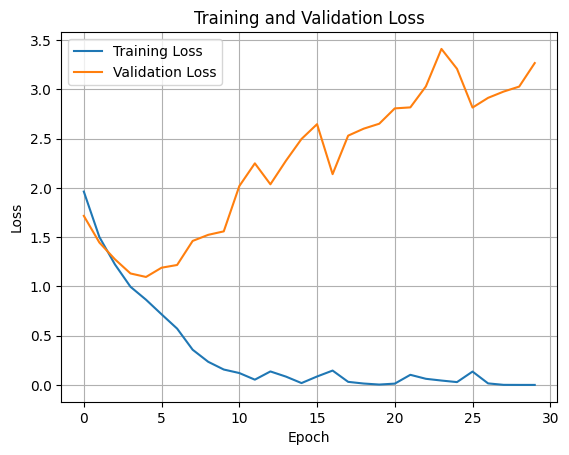

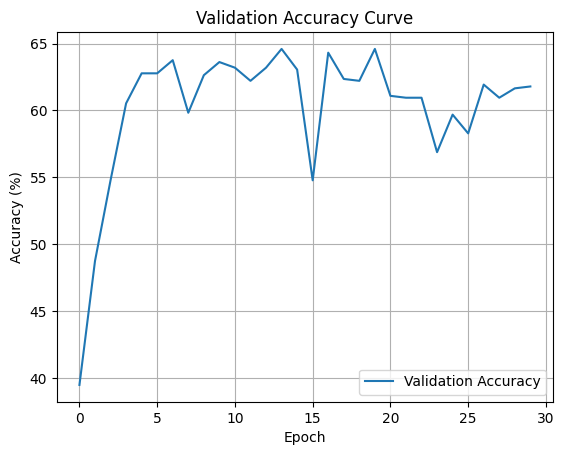

In [20]:
optimizer = optim.Adam(model_1.parameters(), lr=LEARNING_RATE)
# Train 
train_losses, val_losses, val_accs = train_model(
model=model_1,
train_loader=train_loader,
val_loader=valid_loader,
criterion=criterion,
optimizer=optimizer,
num_epochs=30,
device=device,
)

test_metrics = evaluate_model(model_1, test_loader, device=device)
plot_loss_curves(train_losses, val_losses, title="Training and Validation Loss")
plot_acc_curves( val_accs, title="Validation Accuracy Curve")

In [21]:
save_model_and_logs(model_1, "WasteCNN", train_losses, val_losses, val_accs)

✅ Saved model weights to: /kaggle/working/WasteCNN_final.pth
📊 Saved training log to: /kaggle/working/WasteCNN_log.csv
------------------------------------------------------


In [22]:
model_2 = BigWasteCNN(num_classes=NUM_CLASSES)

model_2.to(device)
summary(model_2, input_size=(3, 256, 256))  # (Channels, Height, Width)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 256, 256]             448
       BatchNorm2d-2         [-1, 16, 256, 256]              32
              ReLU-3         [-1, 16, 256, 256]               0
            Conv2d-4         [-1, 16, 256, 256]           2,320
       BatchNorm2d-5         [-1, 16, 256, 256]              32
              ReLU-6         [-1, 16, 256, 256]               0
         MaxPool2d-7         [-1, 16, 128, 128]               0
            Conv2d-8         [-1, 32, 128, 128]           4,640
       BatchNorm2d-9         [-1, 32, 128, 128]              64
             ReLU-10         [-1, 32, 128, 128]               0
           Conv2d-11         [-1, 32, 128, 128]           9,248
      BatchNorm2d-12         [-1, 32, 128, 128]              64
             ReLU-13         [-1, 32, 128, 128]               0
        MaxPool2d-14           [-1, 32,

In [23]:
# optimizer = optim.Adam(model_2.parameters(), lr=LEARNING_RATE)
# # Train 
# train_losses_2, val_losses_2, val_accs_2 = train_model(
# model=model_2,
# train_loader=train_loader,
# val_loader=valid_loader,
# criterion=criterion,
# optimizer=optimizer,
# num_epochs=30,
# device=device,
# )

# test_metrics_2 = evaluate_model(model_2, test_loader, device=device)
# plot_loss_curves(train_losses_2, val_losses_2, title="Training and Validation Loss (model_2:BigWasteCNN)")
# plot_acc_curves( val_accs_2, title="Validation Accuracy Curve (model_2:BigWasteCNN)")

In [24]:
model_3 = ShapeEkeWasteCNN(num_classes=NUM_CLASSES)

model_3.to(device)
summary(model_3, input_size=(3, 256, 256))  # (Channels, Height, Width)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]             896
       BatchNorm2d-2         [-1, 32, 256, 256]              64
              ReLU-3         [-1, 32, 256, 256]               0
         MaxPool2d-4         [-1, 32, 128, 128]               0
            Conv2d-5         [-1, 64, 128, 128]          18,496
       BatchNorm2d-6         [-1, 64, 128, 128]             128
              ReLU-7         [-1, 64, 128, 128]               0
         MaxPool2d-8           [-1, 64, 64, 64]               0
            Conv2d-9          [-1, 128, 64, 64]          73,856
      BatchNorm2d-10          [-1, 128, 64, 64]             256
             ReLU-11          [-1, 128, 64, 64]               0
        MaxPool2d-12          [-1, 128, 32, 32]               0
           Conv2d-13          [-1, 256, 32, 32]         295,168
      BatchNorm2d-14          [-1, 256,

In [25]:
# optimizer = optim.Adam(model_2.parameters(), lr=LEARNING_RATE)
# # Train 
# train_losses_3, val_losses_3, val_accs_3 = train_model(
# model=model_3,
# train_loader=train_loader,
# val_loader=valid_loader,
# criterion=criterion,
# optimizer=optimizer,
# num_epochs=30,
# device=device,
# )

# test_metrics_3 = evaluate_model(model_3, test_loader, device=device)
# plot_loss_curves(train_losses_3, val_losses_3, title="Training and Validation Loss (model_3:ShapeEkeWasteCNN)")
# plot_acc_curves( val_accs_3, title="Validation Accuracy Curve (model_3:ShapeEkeWasteCNN)")

In [26]:
# =====================================================
# Generalized ResNet builder (works for both 18 & 50)
# =====================================================
class RESNET(nn.Module):
    def __init__(self, num_classes, version=18, freeze_backbone=True):
        super(RESNET, self).__init__()

        # Select ResNet version dynamically
        if version == 18:
            self.backbone = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        elif version == 50:
            self.backbone = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
        else:
            raise ValueError("Only ResNet-18 and ResNet-50 supported")

        # Optionally freeze the backbone
        if freeze_backbone:
            for param in self.backbone.parameters():
                param.requires_grad = False

        # Replace the classification head
        in_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return F.log_softmax(self.backbone(x), dim=1)


In [27]:
class ALEXNET(nn.Module):
    def __init__(self, num_classes, freeze_backbone=True):
        super(ALEXNET, self).__init__()
        self.backbone = models.alexnet(weights=models.AlexNet_Weights.IMAGENET1K_V1)

        # Optionally freeze convolutional backbone
        if freeze_backbone:
            for param in self.backbone.features.parameters():
                param.requires_grad = False

        # Correct classifier input = 9216
        self.backbone.classifier = nn.Sequential(
            nn.Linear(9216, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(1024, num_classes)
        )

    def forward(self, x):
        return F.log_softmax(self.backbone(x), dim=1)


In [28]:

model_res18 = RESNET(num_classes=NUM_CLASSES, version=18, freeze_backbone=True)


model_res50 = RESNET(num_classes= NUM_CLASSES, version=50, freeze_backbone=True)


model_alex = ALEXNET(num_classes= NUM_CLASSES, freeze_backbone=True)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 197MB/s]
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 220MB/s]
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 188MB/s]


In [29]:
model_res18.to(device)
summary(model_res18, input_size=(3, 256, 256))  # (Channels, Height, Width)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
       BasicBlock-11           [-1, 64, 64, 64]               0
           Conv2d-12           [-1, 64, 64, 64]          36,864
      BatchNorm2d-13           [-1, 64, 64, 64]             128
             ReLU-14           [-1, 64,

In [30]:
model_res50.to(device)
summary(model_res50, input_size=(3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]           4,096
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
           Conv2d-11          [-1, 256, 64, 64]          16,384
      BatchNorm2d-12          [-1, 256, 64, 64]             512
           Conv2d-13          [-1, 256, 64, 64]          16,384
      BatchNorm2d-14          [-1, 256,

In [31]:
optimizer = optim.Adam(model_res50.parameters(), lr=LEARNING_RATE)
# Train 
train_losses_res18, val_losses_res18, val_accs_res18 = train_model(
model=model_res50,
train_loader=train_loader,
val_loader=valid_loader,
criterion=criterion,
optimizer=optimizer,
num_epochs=100,
device=device,
)



Epoch [1/100] | Train Loss: 0.8291 | Val Loss: 0.5217 | Val Acc: 83.85%
Epoch [2/100] | Train Loss: 0.4447 | Val Loss: 0.4246 | Val Acc: 84.69%
Epoch [3/100] | Train Loss: 0.3267 | Val Loss: 0.3664 | Val Acc: 86.80%
Epoch [4/100] | Train Loss: 0.2644 | Val Loss: 0.3676 | Val Acc: 87.22%
Epoch [5/100] | Train Loss: 0.2043 | Val Loss: 0.3557 | Val Acc: 87.50%
Epoch [6/100] | Train Loss: 0.1750 | Val Loss: 0.4109 | Val Acc: 87.36%
Epoch [7/100] | Train Loss: 0.1443 | Val Loss: 0.4762 | Val Acc: 85.67%
Epoch [8/100] | Train Loss: 0.1608 | Val Loss: 0.4806 | Val Acc: 84.41%
Epoch [9/100] | Train Loss: 0.1408 | Val Loss: 0.3839 | Val Acc: 89.19%
Epoch [10/100] | Train Loss: 0.1088 | Val Loss: 0.4014 | Val Acc: 86.66%
Epoch [11/100] | Train Loss: 0.1312 | Val Loss: 0.3913 | Val Acc: 88.34%
Epoch [12/100] | Train Loss: 0.1123 | Val Loss: 0.4478 | Val Acc: 87.78%
Epoch [13/100] | Train Loss: 0.0987 | Val Loss: 0.3753 | Val Acc: 87.92%
Epoch [14/100] | Train Loss: 0.0944 | Val Loss: 0.3713 | Val


Test Accuracy: 89.22%
Precision: 0.8858, Recall: 0.8988, F1: 0.8911
Confusion Matrix:
 [[ 56   0   0   2   1   9   0   0   0]
 [  0  59   0   0   1   0   0   0   0]
 [  0   0  66   0   1   0   1   0   0]
 [  1   0   1 105   1   0   5   1   2]
 [  1   1   1   0  52   0   2   5   1]
 [  3   0   0   0   3  71   0   0   0]
 [  3   2   9   7   3   0 125   0   0]
 [  0   0   0   0   3   2   0  44   0]
 [  0   4   0   0   1   0   0   0  59]]


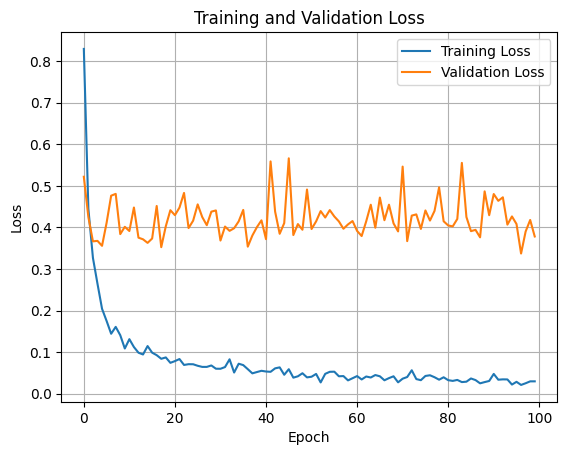

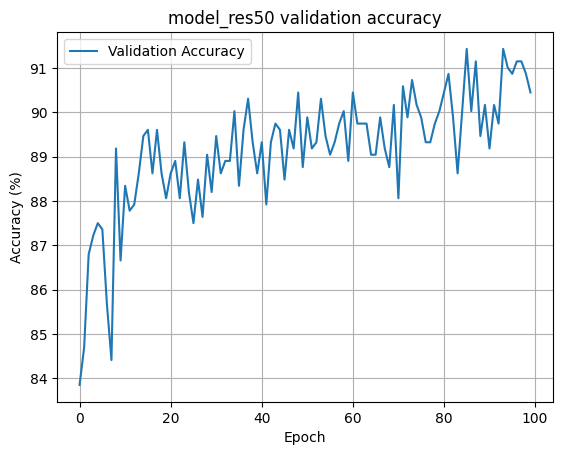

In [32]:
test_metrics_res18 = evaluate_model(model_res50, test_loader, device=device)
plot_loss_curves(train_losses_res18, val_losses_res18)
plot_acc_curves(val_accs_res18, "model_res50 validation accuracy")

In [33]:
model_alex.to(device)
summary(model_alex, input_size=(3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 63, 63]          23,296
              ReLU-2           [-1, 64, 63, 63]               0
         MaxPool2d-3           [-1, 64, 31, 31]               0
            Conv2d-4          [-1, 192, 31, 31]         307,392
              ReLU-5          [-1, 192, 31, 31]               0
         MaxPool2d-6          [-1, 192, 15, 15]               0
            Conv2d-7          [-1, 384, 15, 15]         663,936
              ReLU-8          [-1, 384, 15, 15]               0
            Conv2d-9          [-1, 256, 15, 15]         884,992
             ReLU-10          [-1, 256, 15, 15]               0
           Conv2d-11          [-1, 256, 15, 15]         590,080
             ReLU-12          [-1, 256, 15, 15]               0
        MaxPool2d-13            [-1, 256, 7, 7]               0
AdaptiveAvgPool2d-14            [-1, 25